In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
image_1 = ''.join(["../input/stage1_train/"
                  "0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9/"
                  "images/0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9.png"])

In [13]:
img=cv2.imread(image_1,0)
np.shape(img)

(256, 256)

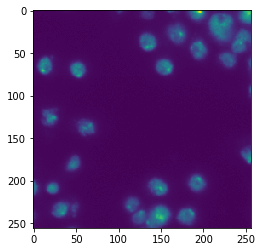

In [4]:
plt.imshow(img)

In [40]:
path_masks_1 = ''.join(["../input/stage1_train/", 
                   "0a7d30b252359a10fd298b638b90cb9ada3acced4e0c0e5a3692013f432ee4e9/masks"])

In [53]:
masks_1=''.join([path_masks_1,"/*.png"])

In [54]:
import glob

masks = [cv2.imread(file,0) for file in glob.glob(masks_1)]

In [17]:
np.shape(masks[0])

(256, 256)

In [18]:
len(masks)

27

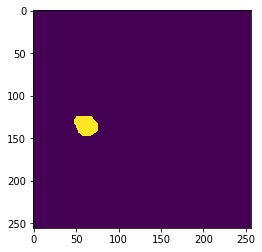

In [55]:
plt.imshow(masks[2])

In [57]:
for i in range(len(masks)):
    masks[i]=np.where(masks[i]>0,1,0)

In [59]:
masks_join=np.zeros((256,256))

for i in range(len(masks)):
    masks_join=masks_join+masks[i]

In [63]:
masks_join = np.where(masks_join>0,1,0)

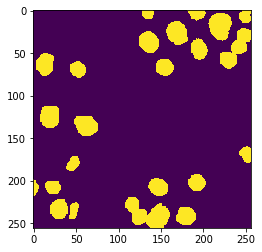

In [60]:
plt.imshow(masks_join)

In [64]:
imgT_mean=np.where(img>np.mean(img),1,0)

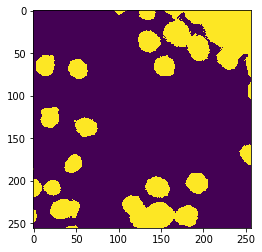

In [65]:
plt.imshow(imgT_mean)

In [68]:
from skimage.filters import threshold_otsu

thresh_val = threshold_otsu(img)
imgT_otsu = np.where(img > thresh_val, 1, 0)

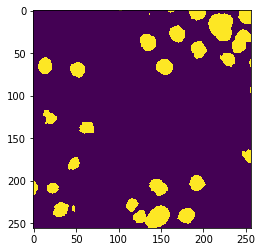

In [69]:
plt.imshow(imgT_otsu)

In [79]:
from skimage.morphology import label

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / float((tp + fp + fn))
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

In [86]:
print("IoU metric for mean threshold for first image")
print(iou_metric(masks_join,imgT_mean,True))
print(" ")
print("IoU metric for otsu threshold for first image")
print(iou_metric(masks_join,imgT_otsu,True))

IoU metric for mean threshold
Thresh	TP	FP	FN	Prec.
0.500	15	11	8	0.441
0.550	14	12	9	0.400
0.600	11	15	12	0.289
0.650	11	15	12	0.289
0.700	7	19	16	0.167
0.750	6	20	17	0.140
0.800	6	20	17	0.140
0.850	3	23	20	0.065
0.900	0	26	23	0.000
0.950	0	26	23	0.000
AP	-	-	-	0.193
0.193107766442
 
IoU metric for otsu threshold
Thresh	TP	FP	FN	Prec.
0.500	18	11	5	0.529
0.550	17	12	6	0.486
0.600	14	15	9	0.368
0.650	12	17	11	0.300
0.700	10	19	13	0.238
0.750	9	20	14	0.209
0.800	6	23	17	0.130
0.850	4	25	19	0.083
0.900	1	28	22	0.020
0.950	0	29	23	0.000
AP	-	-	-	0.236
0.236432062581


In [97]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [98]:
import pandas as pd
from scipy import ndimage

def analyze_image_meanT(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
#     im_id = im_path.parts[-3]
#     im = imageio.imread(str(im_path))
#     im_gray = rgb2gray(im)
    im_id = im_path.parts[-3]
    im=cv2.imread(str(im_path),0)
    
    # Mask out background and extract connected objects
#     thresh_val = threshold_otsu(im_gray)
#     mask = np.where(im_gray > thresh_val, 1, 0)
#     if np.sum(mask==0) < np.sum(mask==1):
#         mask = np.where(mask, 0, 1)    
#         labels, nlabels = ndimage.label(mask)
#     labels, nlabels = ndimage.label(mask)
    thresh_val = np.mean(im)
    mask=np.where(im>thresh_val,1,0)
    labels, nlabels = ndimage.label(mask)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images_meanT(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image_meanT(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [99]:
import pathlib
import time
t0 = time.time()
testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images_meanT(list(testing))
df.to_csv('submissionThres_mean.csv', index=None)
t1 = time.time()

total=t1-t0
print(total)

99.0580499172


In [104]:

def analyze_image_otsuT(im_path):
    '''
    Take an image_path (pathlib.Path object), preprocess and label it, extract the RLE strings 
    and dump it into a Pandas DataFrame.
    '''
    # Read in data and convert to grayscale
    im_id = im_path.parts[-3]
    im = cv2.imread(str(im_path),0)
    #im_gray = rgb2gray(im)
    
    # Mask out background and extract connected objects
    thresh_val = threshold_otsu(im)
    mask = np.where(im > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    # Loop through labels and add each to a DataFrame
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df


def analyze_list_of_images_otsuT(im_path_list):
    '''
    Takes a list of image paths (pathlib.Path objects), analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for im_path in im_path_list:
        im_df = analyze_image_otsuT(im_path)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

In [105]:
import time
t0 = time.time()

testing = pathlib.Path('../input/stage1_test/').glob('*/images/*.png')
df = analyze_list_of_images_otsuT(list(testing))
df.to_csv('submissionThresh_otsu.csv', index=None)

t1=time.time()
total=t1-t0
print(total)

8.32930207253
